# Tutorial CXDI

### Tutor: Julio C. da Silva (ID16A beamline, ESRF) /  email: jdasilva@esrf.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

##### Disclaimer: This notebook is intended from educational reasons only and should not be use for professional data analysis. For the latter, there are other more efficient and complete codes available.

This code run in **Python3** and requires certain python packages, which are: **Numpy, IPython, Matplotlib**

If you do not have those packages, I suggest their installation via pip install: 

    pip3 install numpy, ipython, matplotlib

## CDI Phase Retrieval
This code is inspired by the "Tutorial in Diffraction Imaging" by Gösta Huldt and Filipe Maia (originally in MATLAB), which was available until recenlty at http://xray.bmc.uu.se/~ekeberg/molbiofys/tutorial.pdf.

In [1]:
%matplotlib inline
# standard python packages
import time

# third party packages
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import numpy as np
import scipy.io as sio

# local packages
from tutorial_tools import getViolations

## Load data for the calculations
To facilitate the calculations, we will load the data from files. You can use the files I provide or you can your own intensities previously save to file.

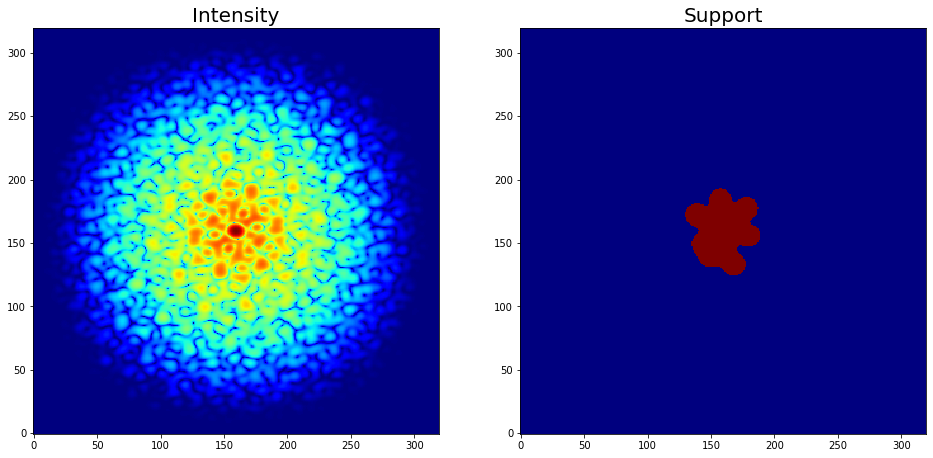

In [2]:
## load .npy file
obj_ints = np.load('myints.npy') # load intensity
rho_original = np.load('myrho.npy') # load rho of the sample
# apodization of the Fourier transform to avoid problem with the edges
window = np.outer(np.hanning(obj_ints.shape[0]),np.hanning(obj_ints.shape[0])) # hanning window to smooth edges
obj_ints *= window # to smooth the high frequencies and avoid problem with the edges

# creating the support. Since we already know rho, we will cheat here for the moment
obj_support = rho_original>0.01 # keep only the values above 0.01. 

# display intensity and support
eps=0.001
fig1 = plt.figure(1,figsize = (16,10))
ax11 = fig1.add_subplot(121)
ax11.imshow(np.log(obj_ints+eps),cmap='jet',origin='lower')
ax11.set_title('Intensity',fontsize=20)
ax12 = fig1.add_subplot(122)
ax12.imshow(obj_support,cmap='jet',origin='lower')
ax12.set_title('Support',fontsize=20)
plt.show(block=False)

## First algorithm: Error reduction (ER)

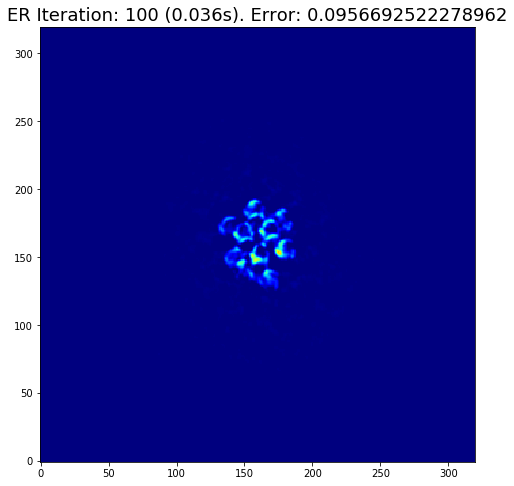

In [3]:
# Number of iterations
numIter = 100

# support
support = obj_support.copy()
# intensities
ints = obj_ints.copy()
# Obtaining the amplitude from the intensity
amplitudes = np.sqrt(ints)
# first guess of the sample
rho = support.copy()*np.ones_like(ints) # with ones within the support
#np.random.seed(10) # to keep the same seed if you run the code twice
#rho = support.copy()*np.random.rand(ints.shape[0],ints.shape[1]) # with random numbers within the support
# shifting the function for the Discrete Fourier Transform
amplitudes = np.fft.ifftshift(amplitudes)
support = np.fft.ifftshift(support)
rho = np.fft.ifftshift(rho)

## ER main loop
E = np.zeros(numIter)# initializing the error function 
fig1 = plt.figure(1,figsize=(8,8))
ax1 = fig1.add_subplot(111)
im1 = ax1.imshow(np.real(np.fft.fftshift(rho)),cmap='jet',origin='lower',vmin=0,vmax=0.3)
for ii in range(numIter):
    t0 = time.time()
    F = np.fft.fft2(rho) # Discret Fourier Transform of the initial guess
    phases = np.angle(F) # keep random phases
    #-----------------------------------
    F = amplitudes*np.exp(1j*phases) # replace experimental amplitudes
    #-----------------------------------
    rho = np.fft.ifft2(F) # Inverse Fourier transform of the current results
    E[ii] = np.sum(np.abs(rho[np.where(support==0)])**2)
    tf = time.time()
    # display figures
    im1.set_data(np.real(np.fft.fftshift(rho)))
    ax1.set_title('ER Iteration: {} ({:0.03f}s). Error: {}'.format(ii+1,tf-t0,E[ii]),fontsize=18)
    display.display(ax1.get_figure())
    display.clear_output(wait=True)
    time.sleep(0.001)
    #------------------------------------
    rho = rho*support # support constraint
    rho[np.where(np.real(rho)<0)]=0 # positivity constraint
    #------------------------------------

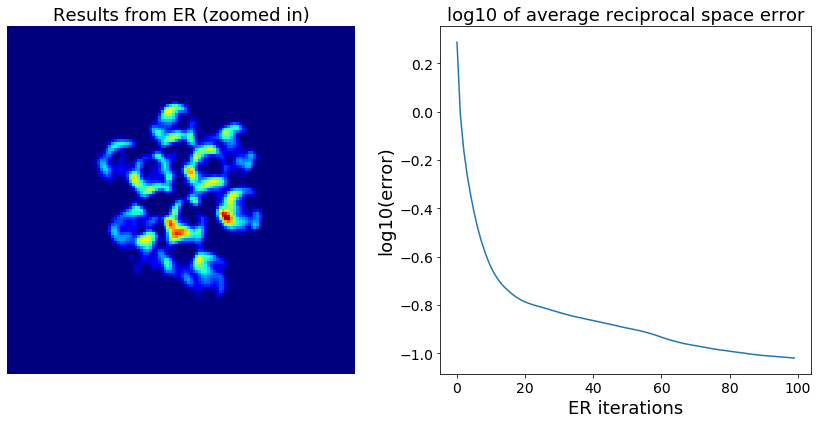

In [4]:
# plot results and errors
creg = 100 # amount of pixel to crop at each border for zooming in 
fig2 = plt.figure(2,figsize=(12,6))
ax21 = fig2.add_subplot(121)
ax21.imshow(np.real(np.fft.fftshift(rho))[creg:-creg,creg:-creg],cmap='jet',origin='lower')#,vmin=0,vmax=0.2)
ax21.set_title('Results from ER (zoomed in)',fontsize=18)
ax21.set_axis_off()
ax22 = fig2.add_subplot(122)
ax22.plot(np.log10(E))
ax22.set_title('log10 of average reciprocal space error',fontsize=18)
ax22.set_xlabel('ER iterations',fontsize = 18)
ax22.set_ylabel('log10(error)',fontsize = 18)
ax22.tick_params(axis='both',which='major',labelsize=14)
plt.tight_layout()
plt.show(block=False)

## Obtaining the support from autocorrelation of the intensities

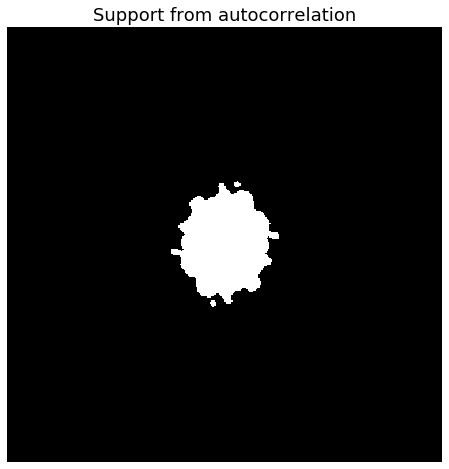

In [5]:
# Intensity
ints = obj_ints
# calculate the autocorrelation function to obtain the object support
autocorrelation = np.fft.fftshift(np.abs(np.fft.ifftn(ints)))
# sample support based on the autocorrelation 
support = autocorrelation>0.1*autocorrelation.max()

# display figure with the support
fig3 = plt.figure(3,figsize=(8,8))
ax3 = fig3.add_subplot(111)
ax3.imshow(support.astype(np.int),cmap='gray',origin='lower')
ax3.set_title('Support from autocorrelation',fontsize=18)
ax3.set_axis_off()
plt.show(block=False)

## Second algorithm: Hybrid Input-Output (HIO) using support from autocorrelation

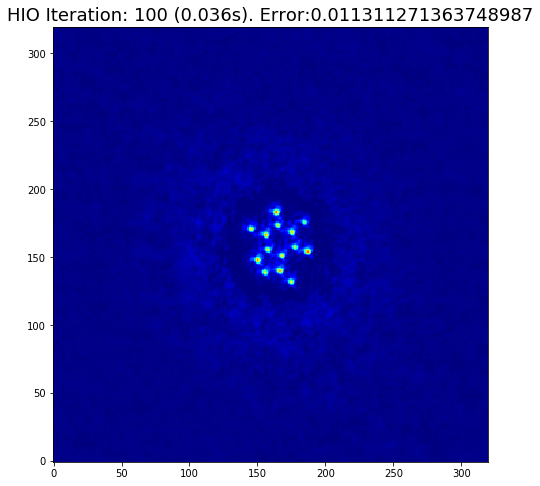

In [6]:
## Settings 
numIter = 100 # Number of iterations
beta = 1.0 # beta factor -> parameter of the HIO error function

## sample support based on the autocorrelation (repeating here for convenience)
support = autocorrelation>0.1*autocorrelation.max()
## support = matsup['support'] # uncomment this line if you want to try this support
# Obtaining the amplitude from the intensity
amplitudes = np.sqrt(ints)
# first guess of the sample
np.random.seed(10) # to keep the same seed if you run the code twice
rho = support.copy()*np.random.rand(ints.shape[0],ints.shape[1])
#rho = support.copy()*np.ones_like(ints)
# shifting the function for the Discrete Fourier Transform
amplitudes = np.fft.fftshift(amplitudes)
support = np.fft.fftshift(support)
rho = np.fft.fftshift(rho)

## HIO main loop
E = np.zeros(numIter) # initializing the error function 
fig4 = plt.figure(4,figsize=(8,8))
plt.clf()
ax4 = fig4.add_subplot(111)
im4 = ax4.imshow(np.real(np.fft.fftshift(rho)),cmap='jet',origin='lower',vmin=0,vmax=0.3)
rho1 = rho.copy() # renaming variable for organization
for ii in range(numIter):
    t0 = time.time()
    F = np.fft.fft2(rho1) # Discret Fourier Transform of the initial guess
    phases = np.angle(F) # keep random phases
    #--------------------------------------------
    F = amplitudes*np.exp(1j*phases) # replace experimental amplitudes
    #--------------------------------------------
    rho2 = np.fft.ifft2(F) # Inverse Fourier transform of the current results
    violations = getViolations(rho2, support)   # get indices where constraints are violated
    E[ii] = np.sum(np.abs(rho2[violations])**2) # error function
    rho3 = rho2.copy() # initializing rho3
    #--------------------------------------------
    # HIO constraints
    rho3[violations] = rho1[violations] - beta*rho2[violations]  # give those violation areas a new value
    rho3[np.where(np.real(rho3)<0)]=0 # positivity constraint
    #--------------------------------------------
    rho1 = rho3     # updating current guess of the object
    tf = time.time()
    # display figures
    im4.set_data(np.real(np.fft.fftshift(rho1)))
    ax4.set_title('HIO Iteration: {} ({:0.03f}s). Error:{}'.format(ii+1,tf-t0,E[ii]),fontsize=18)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.0001)

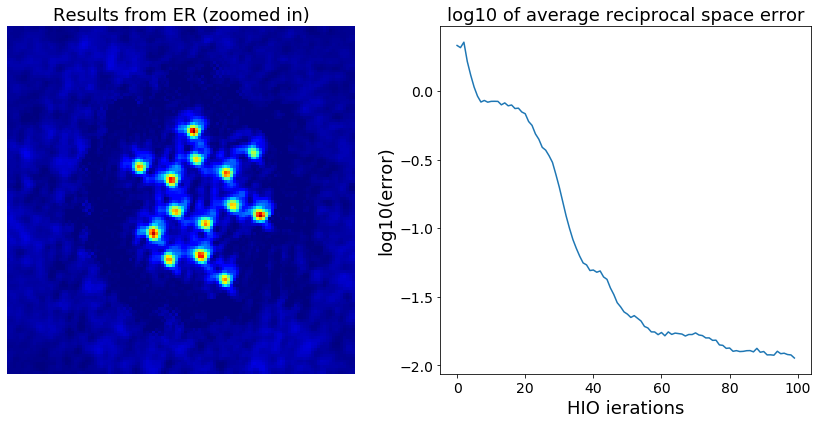

In [7]:
creg = 100 # amount of pixel to crop at each border for zooming in 
# plot results and error
fig5 = plt.figure(5,figsize=(12,6))
ax51 = fig5.add_subplot(121)
ax51.imshow(np.real(np.fft.fftshift(rho1))[creg:-creg,creg:-creg],cmap='jet',origin='lower',vmin=0)
ax51.set_title('Results from ER (zoomed in)',fontsize=18)
ax51.set_axis_off()
ax52 = fig5.add_subplot(122)
ax52.plot(np.log10(E))
ax52.set_title('log10 of average reciprocal space error',fontsize=18)
ax52.set_xlabel('HIO ierations',fontsize = 18)
ax52.set_ylabel('log10(error)',fontsize = 18)
ax52.tick_params(axis='both',which='major',labelsize=14)
plt.tight_layout()
plt.show(block=False)

## Congratulations! You have perform the CDI phase retrieval using ER and HIO algorithms